In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras import callbacks
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [44]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 666.1/666.1 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 7.4 MB/s eta 0:00:00a 0:00:01


In [15]:
!pip install tensorflow


In [16]:
data = pd.read_csv("/Users/serengeti/Downloads/traffic.csv")
data.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [17]:
data["DateTime"]= pd.to_datetime(data["DateTime"])
data = data.drop(["ID"], axis=1) #dropping IDs
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  48120 non-null  datetime64[ns]
 1   Junction  48120 non-null  int64         
 2   Vehicles  48120 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.1 MB


Text(0.5, 0, 'Date')

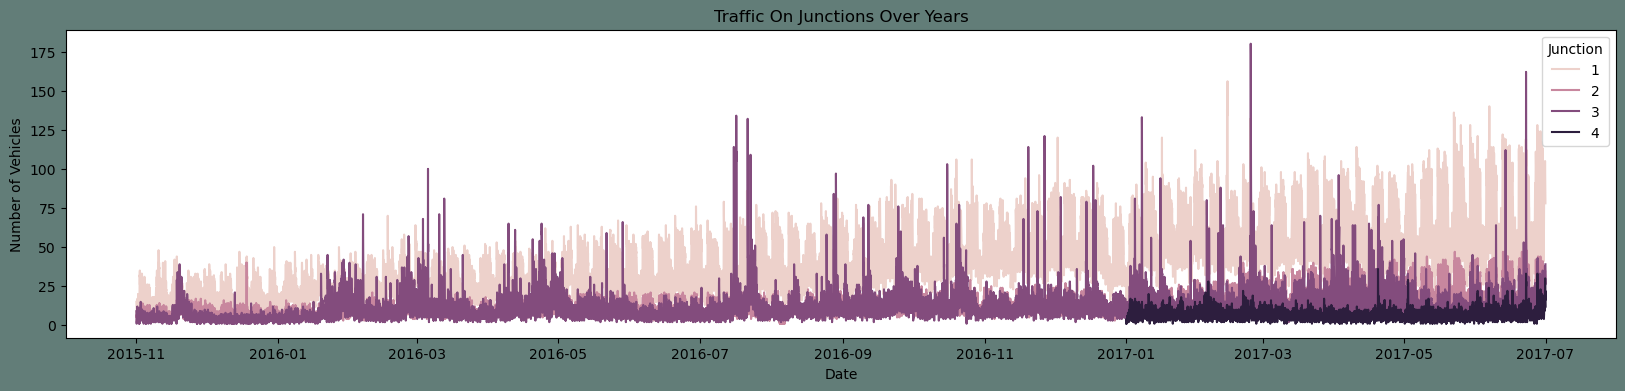

In [18]:
df=data.copy() 
#Let's plot the Timeseries

plt.figure(figsize=(20,4),facecolor="#627D78")
Time_series=sns.lineplot(x=df['DateTime'],y="Vehicles",data=df, hue="Junction")
Time_series.set_title("Traffic On Junctions Over Years")
Time_series.set_ylabel("Number of Vehicles")
Time_series.set_xlabel("Date")

In [19]:
df["Year"]= df['DateTime'].dt.year
df["Month"]= df['DateTime'].dt.month
df["Date_no"]= df['DateTime'].dt.day
df["Hour"]= df['DateTime'].dt.hour
df["Day"]= df.DateTime.dt.strftime("%A")
df.head()

,DateTime,Junction,Vehicles,Year,Month,Date_no,Hour,Day
0,2015-11-01 00:00:00,1,15,2015,11,1,0,Sunday
1,2015-11-01 01:00:00,1,13,2015,11,1,1,Sunday
2,2015-11-01 02:00:00,1,10,2015,11,1,2,Sunday
3,2015-11-01 03:00:00,1,7,2015,11,1,3,Sunday
4,2015-11-01 04:00:00,1,9,2015,11,1,4,Sunday


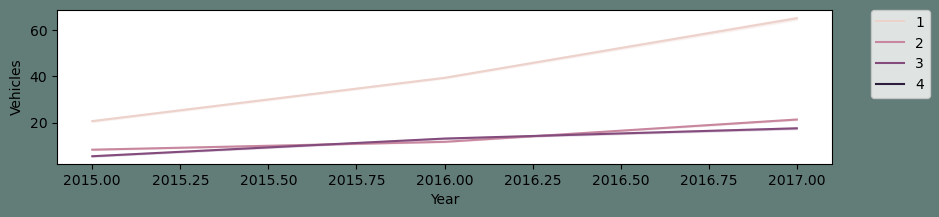

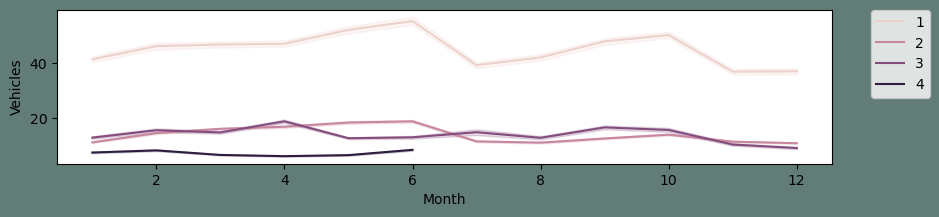

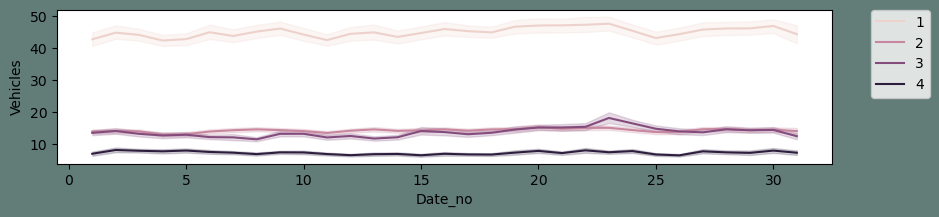

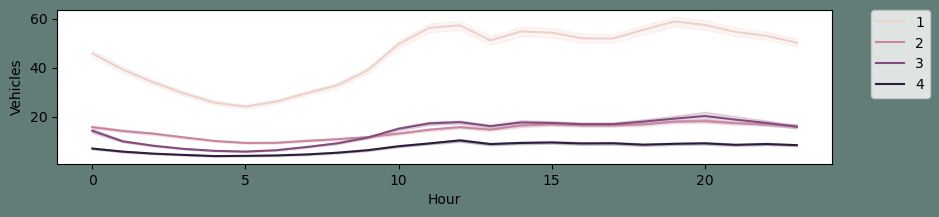

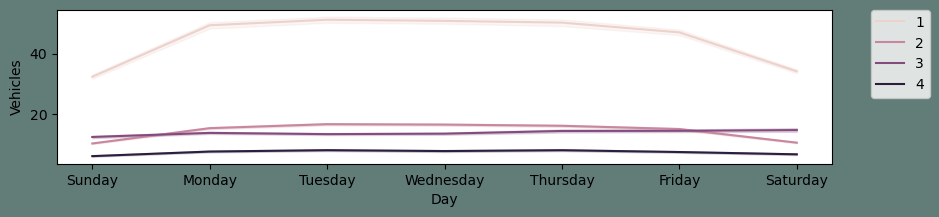

In [20]:
new_features = [ "Year","Month", "Date_no", "Hour", "Day"]

for i in new_features:
    plt.figure(figsize=(10,2),facecolor="#627D78")
    ax=sns.lineplot(x=df[i],y="Vehicles",data=df, hue="Junction" )
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

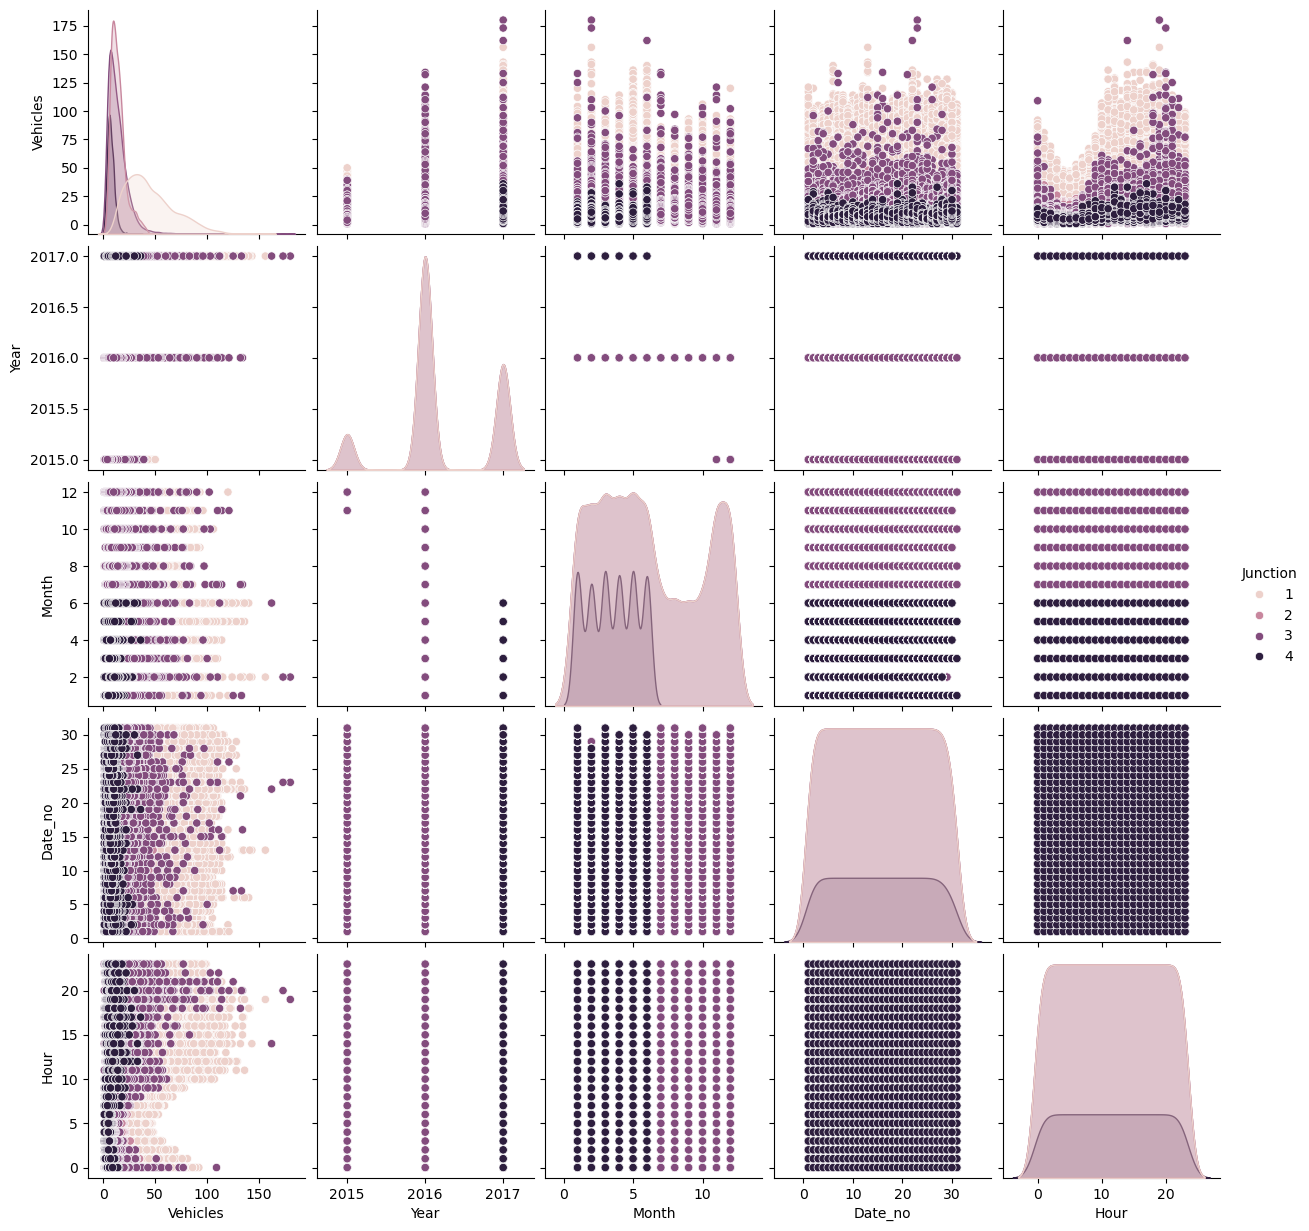

In [21]:
sns.pairplot(data=df, hue= "Junction")

In [22]:
df_J = data.pivot(columns="Junction", index="DateTime")
df_J.describe()

Vehicles                                         
Junction             1             2             3            4
count     14592.000000  14592.000000  14592.000000  4344.000000
mean         45.052906     14.253221     13.694010     7.251611
std          23.008345      7.401307     10.436005     3.521455
min           5.000000      1.000000      1.000000     1.000000
25%          27.000000      9.000000      7.000000     5.000000
50%          40.000000     13.000000     11.000000     7.000000
75%          59.000000     17.000000     18.000000     9.000000
max         156.000000     48.000000    180.000000    36.000000

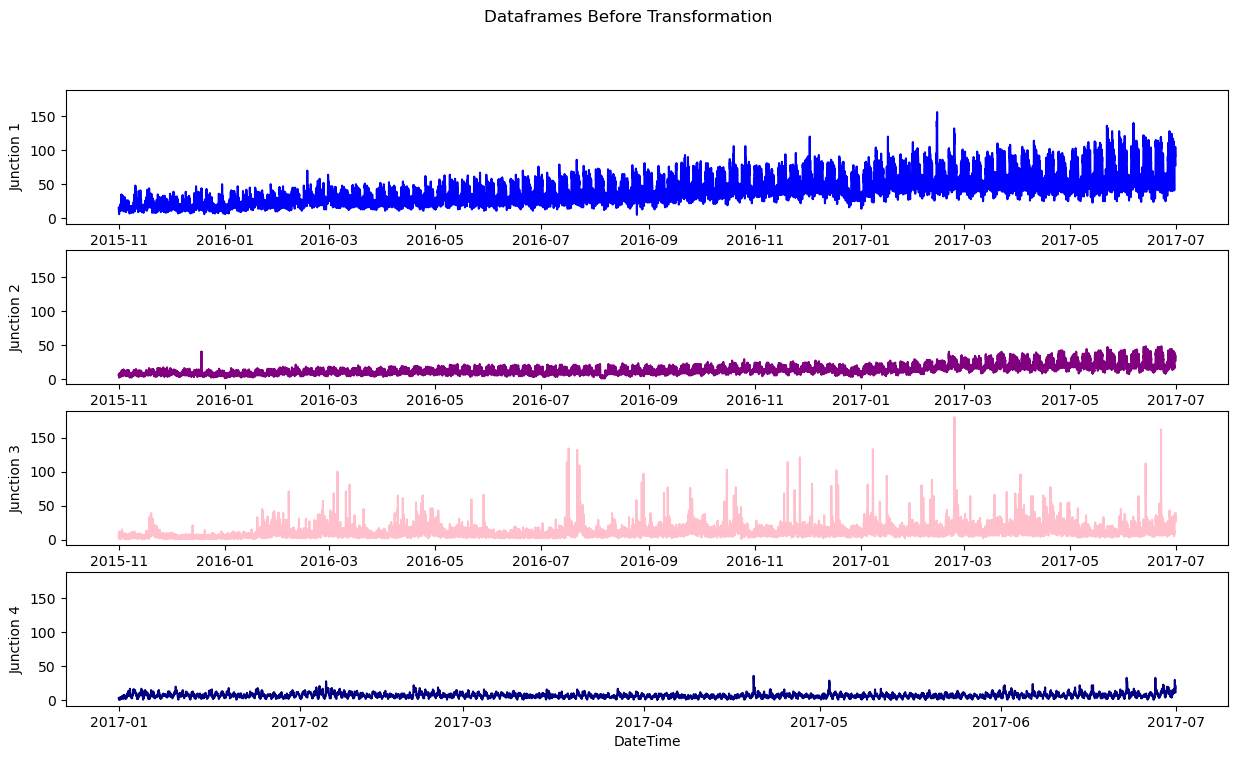

In [23]:
#Creating new sets
df_1 = df_J[[('Vehicles', 1)]]
df_2 = df_J[[('Vehicles', 2)]]
df_3 = df_J[[('Vehicles', 3)]]
df_4 = df_J[[('Vehicles', 4)]]
df_4 = df_4.dropna() #Junction 4 has limited data only for a few months
colors=["blue","purple","pink","navy"]
#Dropping level one in dfs's index as it is a multi index data frame
list_dfs = [df_1, df_2, df_3, df_4]
for i in list_dfs:
    i.columns= i.columns.droplevel(level=1)   

#Function to plot comparitive plots of dataframes
def Sub_Plots4(df_1, df_2,df_3,df_4,title):
    fig, axes = plt.subplots(4, 1, figsize=(15, 8), sharey=True)
    fig.suptitle(title)
    #J1
    pl_1=sns.lineplot(ax=axes[0],data=df_1,color=colors[0])
    #pl_1=plt.ylabel()
    axes[0].set(ylabel ="Junction 1")
    #J2
    pl_2=sns.lineplot(ax=axes[1],data=df_2,color=colors[1])
    axes[1].set(ylabel ="Junction 2")
    #J3
    pl_3=sns.lineplot(ax=axes[2],data=df_3,color=colors[2])
    axes[2].set(ylabel ="Junction 3")
    #J4
    pl_4=sns.lineplot(ax=axes[3],data=df_4,color=colors[3])
    axes[3].set(ylabel ="Junction 4")
    
    
#Plotting the dataframe to check for stationarity
Sub_Plots4(df_1.Vehicles, df_2.Vehicles,df_3.Vehicles,df_4.Vehicles,"Dataframes Before Transformation")

In [30]:
# Normalize Function
def Normalize(df,col):
    average = df[col].mean()
    stdev = df[col].std()
    df_normalized = (df[col] - average) / stdev
    df_normalized = df_normalized.to_frame()
    return df_normalized, average, stdev

# Differencing Function
def Difference(df,col, interval):
    diff = []
    for i in range(interval, len(df)):
        value = df[col][i] - df[col][i - interval]
        diff.append(value)
    return diff

In [32]:
#Normalizing and Differencing to make the series stationary 
df_N1, av_J1, std_J1 = Normalize(df_1, "Vehicles")
Diff_1 = Difference(df_N1, col="Vehicles", interval=(24*7)) #taking a week's diffrence
df_N1 = df_N1[24*7:]
df_N1.columns = ["Norm"]
df_N1["Diff"]= Diff_1

df_N2, av_J2, std_J2 = Normalize(df_2, "Vehicles")
Diff_2 = Difference(df_N2, col="Vehicles", interval=(24)) #taking a day's diffrence
df_N2 = df_N2[24:]
df_N2.columns = ["Norm"]
df_N2["Diff"]= Diff_2

df_N3, av_J3, std_J3 = Normalize(df_3, "Vehicles")
Diff_3 = Difference(df_N3, col="Vehicles", interval=1) #taking an hour's diffrence
df_N3 = df_N3[1:]
df_N3.columns = ["Norm"]
df_N3["Diff"]= Diff_3

df_N4, av_J4, std_J4 = Normalize(df_4, "Vehicles")
Diff_4 = Difference(df_N4, col="Vehicles", interval=1) #taking an hour's diffrence
df_N4 = df_N4[1:]
df_N4.columns = ["Norm"]
df_N4["Diff"]= Diff_4

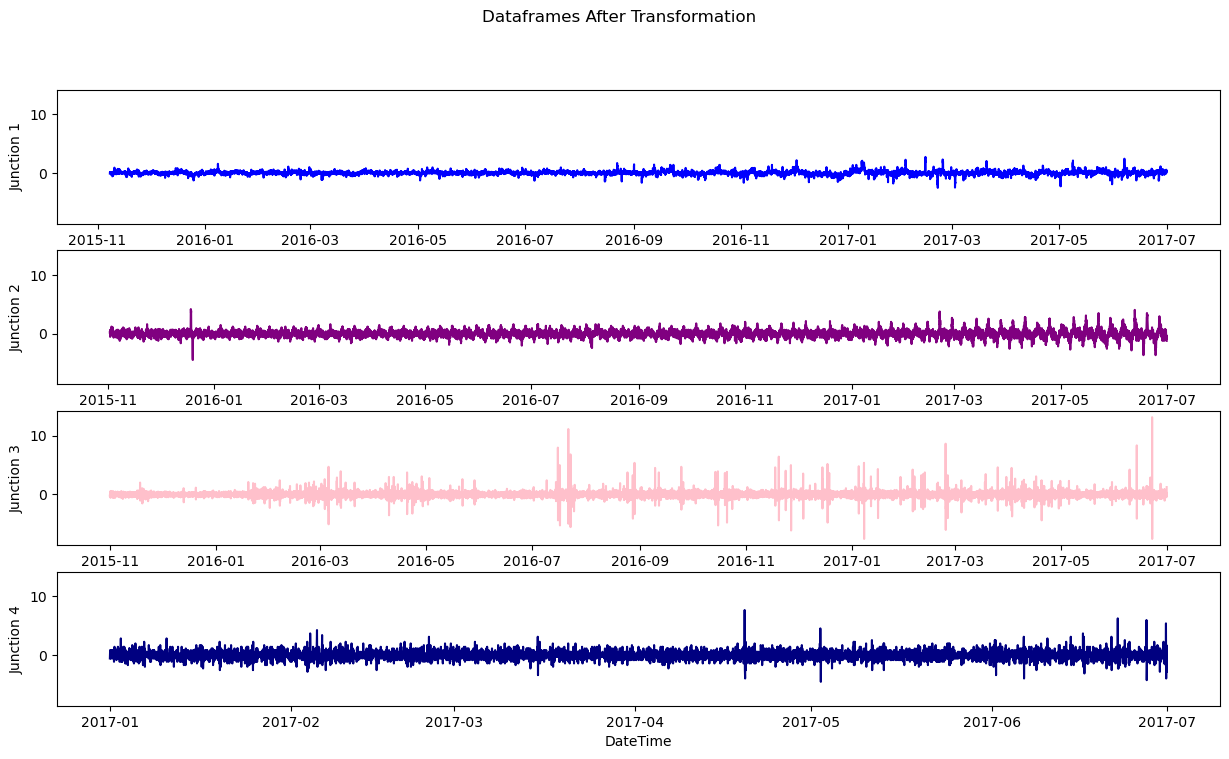

In [34]:
Sub_Plots4(df_N1.Diff, df_N2.Diff,df_N3.Diff,df_N4.Diff,"Dataframes After Transformation")

In [38]:
def Stationary_check(df):
    check = adfuller(df.dropna())
    print(f"ADF Statistic: {check[0]}")
    print(f"p-value: {check[1]}")
    print("Critical Values:")
    for key, value in check[4].items():
        print('\t%s: %.3f' % (key, value))
    if check[0] > check[4]["1%"]:
        print("Time Series is Non-Stationary")
    else:
        print("Time Series is Stationary") 
  

#Checking if the series is stationary

List_df_ND = [ df_N1["Diff"], df_N2["Diff"], df_N3["Diff"], df_N4["Diff"]] 
print("Checking the transformed series for stationarity:")
for i in List_df_ND:
    print("\n")
    Stationary_check(i)

Checking the transformed series for stationarity:


ADF Statistic: -15.2653033904156
p-value: 4.798539876394377e-28
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -21.79589102694008
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -28.00175990883264
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -17.97909256305224
p-value: 2.77878753259558e-30
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Time Series is Stationary


In [40]:
#Differencing created some NA values as we took a weeks data into consideration while difrencing
df_J1 = df_N1["Diff"].dropna()
df_J1 = df_J1.to_frame()

df_J2 = df_N2["Diff"].dropna()
df_J2 = df_J2.to_frame()

df_J3 = df_N3["Diff"].dropna()
df_J3 = df_J3.to_frame()

df_J4 = df_N4["Diff"].dropna()
df_J4 = df_J4.to_frame()

#Splitting the dataset
def Split_data(df):
    training_size = int(len(df)*0.90)
    data_len = len(df)
    train, test = df[0:training_size],df[training_size:data_len] 
    train, test = train.values.reshape(-1, 1), test.values.reshape(-1, 1)
    return train, test
#Splitting the training and test datasets 
J1_train, J1_test = Split_data(df_J1)
J2_train, J2_test = Split_data(df_J2)
J3_train, J3_test = Split_data(df_J3)
J4_train, J4_test = Split_data(df_J4)

#Target and Feature
def TnF(df):
    end_len = len(df)
    X = []
    y = []
    steps = 32
    for i in range(steps, end_len):
        X.append(df[i - steps:i, 0])
        y.append(df[i, 0])
    X, y = np.array(X), np.array(y)
    return X ,y

#fixing the shape of X_test and X_train
def FeatureFixShape(train, test):
    train = np.reshape(train, (train.shape[0], train.shape[1], 1))
    test = np.reshape(test, (test.shape[0],test.shape[1],1))
    return train, test

#Assigning features and target 
X_trainJ1, y_trainJ1 = TnF(J1_train)
X_testJ1, y_testJ1 = TnF(J1_test)
X_trainJ1, X_testJ1 = FeatureFixShape(X_trainJ1, X_testJ1)

X_trainJ2, y_trainJ2 = TnF(J2_train)
X_testJ2, y_testJ2 = TnF(J2_test)
X_trainJ2, X_testJ2 = FeatureFixShape(X_trainJ2, X_testJ2)

X_trainJ3, y_trainJ3 = TnF(J3_train)
X_testJ3, y_testJ3 = TnF(J3_test)
X_trainJ3, X_testJ3 = FeatureFixShape(X_trainJ3, X_testJ3)

X_trainJ4, y_trainJ4 = TnF(J4_train)
X_testJ4, y_testJ4 = TnF(J4_test)
X_trainJ4, X_testJ4 = FeatureFixShape(X_trainJ4, X_testJ4)

{'J1'}
Finding best ARIMA(p,1,q) parameters...
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-4106.640, Time=3.27 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=6946.576, Time=0.34 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-3053.515, Time=0.20 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1304.694, Time=0.54 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-4051.778, Time=1.58 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-4053.288, Time=0.70 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-4049.532, Time=1.40 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-4050.047, Time=4.30 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-4006.477, Time=0.81 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-4050.472, Time=1.66 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-4052.608, Time=1.80 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=5.95 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-4051.352, Time=6.67 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0]          


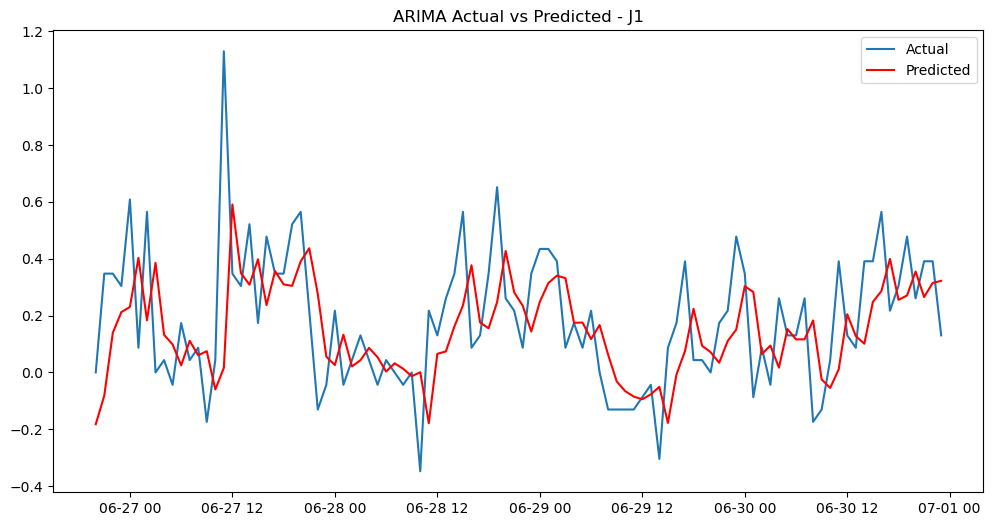

MAE - J1: 0.1721
RMSE - J1: 0.2270
{'J2'}
Finding best ARIMA(p,1,q) parameters...
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=14215.779, Time=4.44 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=22281.527, Time=0.38 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=16571.100, Time=0.27 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=19004.712, Time=0.44 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=14378.711, Time=1.29 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=14379.096, Time=1.07 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=14377.631, Time=1.66 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=14244.777, Time=10.55 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=14381.449, Time=2.21 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=14371.096, Time=2.72 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=14373.377, Time=3.09 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=14383.032, Time=6.77 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=14386.158, Time=3.39 sec

Be

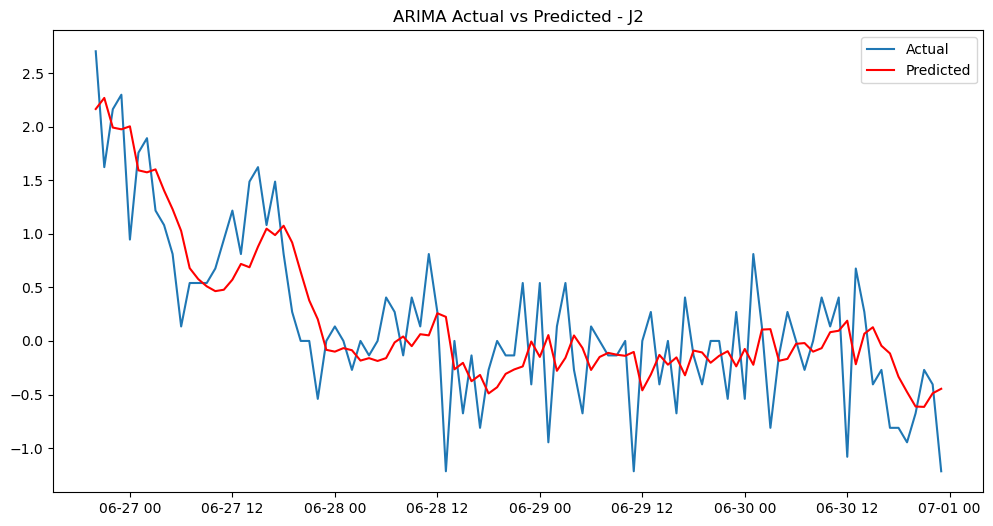

MAE - J2: 0.4011
RMSE - J2: 0.5046
{'J3'}
Finding best ARIMA(p,1,q) parameters...
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=19984.553, Time=5.60 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=21597.504, Time=0.46 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=21597.169, Time=0.26 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=21596.745, Time=0.46 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=20271.206, Time=2.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=20261.626, Time=1.82 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=6.38 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=20274.851, Time=8.39 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=20379.419, Time=1.60 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=20261.794, Time=4.31 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=20245.891, Time=3.85 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=8.98 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=20152.367, Time=14.67 sec

Best model:  A

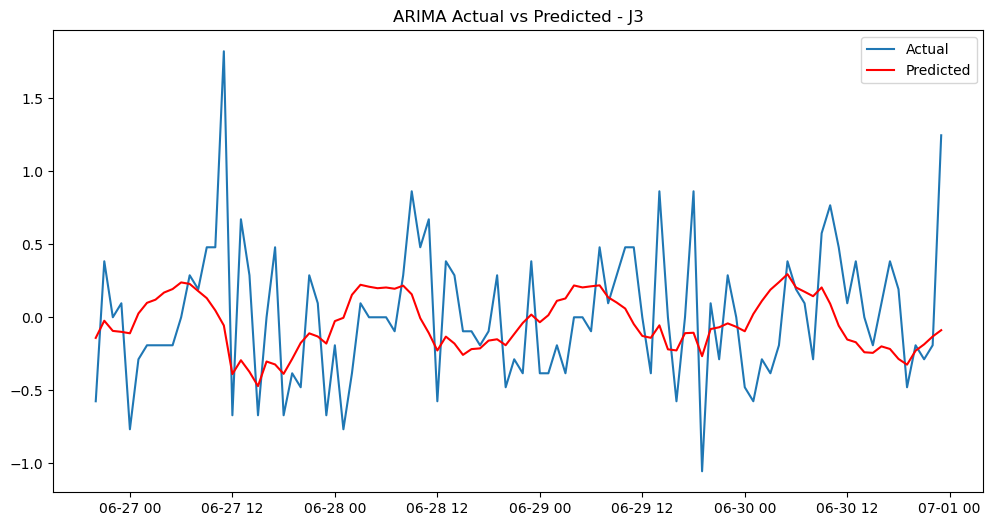

MAE - J3: 0.3624
RMSE - J3: 0.4606
{'J4'}
Finding best ARIMA(p,1,q) parameters...
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=8923.157, Time=0.80 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=9624.434, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=9063.269, Time=0.15 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8920.062, Time=0.23 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=8921.521, Time=0.32 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=8921.512, Time=0.18 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=8921.653, Time=1.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=8922.058, Time=0.36 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 3.219 seconds

Best Model Order for J4: ARIMA(0, 0, 1)


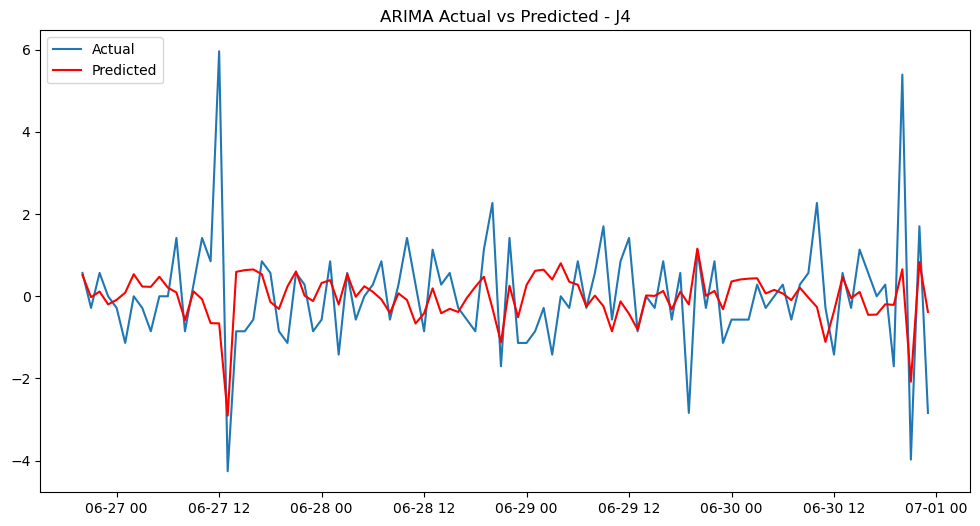

MAE - J4: 0.8738
RMSE - J4: 1.2725


In [46]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Dictionary of your datasets
dataframes = {'J1': df_J1,'J2': df_J2, 'J3': df_J3, 'J4': df_J4}

# Loop through each dataset
for name, df in dataframes.items():
    print({name})

    # Split train/test (90/10)
    train_size = int(len(df) * 0.9)
    train_data = df.iloc[:train_size]
    test_data = df.iloc[train_size:]

    # Use auto_arima with fixed d=1 (non-seasonal)
    print("Finding best ARIMA(p,1,q) parameters...")
    auto_model = pm.auto_arima(
        train_data,             # fixed differencing
        seasonal=False,
        stepwise=True,      # faster search
        trace=True,         # show progress
        suppress_warnings=True
    )

    # Print best order
    print(f"\nBest Model Order for {name}: ARIMA{auto_model.order}")

    # Fit ARIMA model using discovered (p,1,q)
    model = ARIMA(df, order=(auto_model.order))
    results = model.fit()

    # Forecast last 100 points
    predictions = results.predict(start=len(df)-100, end=len(df)-1)

    


    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(df.index[-100:], df.values[-100:], label='Actual')
    plt.plot(df.index[-100:], predictions, label='Predicted', color='red')
    plt.title(f'ARIMA Actual vs Predicted - {name}')
    plt.legend()
    plt.show()

    # Compute metrics
    mae = mean_absolute_error(df.values[-100:], predictions)
    rmse = np.sqrt(mean_squared_error(df.values[-100:], predictions))

    print(f"MAE - {name}: {mae:.4f}")
    print(f"RMSE - {name}: {rmse:.4f}")


In [47]:
dataframes = {'J1': df_J1,'J2': df_J2, 'J3': df_J3, 'J4': df_J4}
preds={ }
# Loop through each dataset
for name, df in dataframes.items():
    predictions = results.predict(start=len(df)-100, end=len(df)-1)
    preds[name]=predictions
    preds[name]

In [ ]:
preds

In [48]:
# Define mapping (raw_map) used to invert normalization + differencing
# This must exist before the cell that reconstructs predictions (the cell that uses `raw_map`).
raw_map = {
    'J1': {'raw_df': df_1, 'diff_df': df_J1, 'mean': av_J1, 'std': std_J1, 'interval': 24*7},
    'J2': {'raw_df': df_2, 'diff_df': df_J2, 'mean': av_J2, 'std': std_J2, 'interval': 24*7},
    'J3': {'raw_df': df_3, 'diff_df': df_J3, 'mean': av_J3, 'std': std_J3, 'interval': 24*7},
    'J4': {'raw_df': df_4, 'diff_df': df_J4, 'mean': av_J4, 'std': std_J4, 'interval': 24*7},
}
print("Defined raw_map for keys:", list(raw_map.keys()))

Defined raw_map for keys: ['J1', 'J2', 'J3', 'J4']


In [49]:
# Invert predicted diffs -> reconstructed normalized values -> real vehicle counts
# This cell intentionally assigns `real_preds` and `norm_preds` rather than returning them (not inside a function).
real_preds = {}
norm_preds = {}

for name, pred_vals in preds.items():
    if pred_vals is None:
        continue

    cfg = raw_map.get(name)
    if cfg is None:
        raise KeyError(f"No mapping provided for {name}")

    raw_df = cfg['raw_df']        # original Vehicles df (full length)
    diff_df = cfg['diff_df']      # the differenced df used for model (e.g., df_J1)
    mean = cfg['mean']
    std = cfg['std']
    k = cfg['interval']

    # Ensure numpy array for preds
    pred_arr = np.array(pred_vals).ravel()

    # Recompute normalized full series from raw vehicles (full length)
    if isinstance(raw_df, pd.DataFrame):
        if 'Vehicles' in raw_df.columns:
            raw_vehicles = raw_df['Vehicles'].astype(float).values
        else:
            raw_vehicles = raw_df.iloc[:, 0].astype(float).values
    elif isinstance(raw_df, pd.Series):
        raw_vehicles = raw_df.astype(float).values
    else:
        raise TypeError("raw_df must be a pandas DataFrame or Series")

    norm_full = (raw_vehicles - mean) / std

    # Observed diffs (length = len(norm_full) - k)
    diff_obs = norm_full[k:] - norm_full[:-k]

    m = len(diff_obs)
    p = len(pred_arr)
    if p > m:
        raise ValueError(f"Number of predictions ({p}) is larger than available diff length ({m}) for {name}")

    start_replace = m - p

    # Replace last p observed diffs with predicted diffs
    diff_combined = diff_obs.copy()
    diff_combined[start_replace:start_replace + p] = pred_arr

    # Reconstruct normalized series by inverse differencing
    norm_recon = norm_full.copy()
    for t in range(m):
        j = t + k
        norm_recon[j] = diff_combined[t] + norm_recon[t]

    # Extract the reconstructed normalized values corresponding to predictions
    pred_indices_in_norm = np.arange(k + start_replace, k + m)
    norm_pred_values = norm_recon[pred_indices_in_norm]

    # Convert back to real vehicle counts
    real_pred_values = (norm_pred_values * std) + mean

    # Build timestamps for the predicted positions from diff_df index
    try:
        timestamps = diff_df.index[start_replace:start_replace + p]
        pred_series = pd.Series(real_pred_values, index=timestamps, name='predicted')
        norm_series = pd.Series(norm_pred_values, index=timestamps, name='norm_pred')
    except Exception:
        pred_series = pd.Series(real_pred_values, name='predicted')
        norm_series = pd.Series(norm_pred_values, name='norm_pred')

    real_preds[name] = pred_series
    norm_preds[name] = norm_series

# Summary output
print('Reconstructed predictions for:', list(real_preds.keys()))
for name, s in real_preds.items():
    print(f"\n{name}: {len(s)} predicted points — sample:")
    print(s.head(5))

# Combined DataFrame for easy inspection (columns: J1_pred, J2_pred, ...)
combined = pd.concat(real_preds, axis=1)
combined.columns = [f"{n}_pred" for n in combined.columns.get_level_values(0)]


Reconstructed predictions for: ['J1', 'J2', 'J3', 'J4']

J1: 100 predicted points — sample:
DateTime
2017-06-26 20:00:00    107.019827
2017-06-26 21:00:00     95.019827
2017-06-26 22:00:00     91.019827
2017-06-26 23:00:00     90.019827
2017-06-27 00:00:00     78.019827
Name: predicted, dtype: float64

J2: 100 predicted points — sample:
DateTime
2017-06-20 20:00:00    41.006378
2017-06-20 21:00:00    40.006378
2017-06-20 22:00:00    40.006378
2017-06-20 23:00:00    37.006378
2017-06-21 00:00:00    35.006378
Name: predicted, dtype: float64

J3: 100 predicted points — sample:
DateTime
2017-06-19 21:00:00    27.008993
2017-06-19 22:00:00    20.008993
2017-06-19 23:00:00    34.008993
2017-06-20 00:00:00    25.008993
2017-06-20 01:00:00    16.008993
Name: predicted, dtype: float64

J4: 100 predicted points — sample:
DateTime
2017-06-19 21:00:00     8.809262
2017-06-19 22:00:00     7.919342
2017-06-19 23:00:00    11.406426
2017-06-20 00:00:00     5.303802
2017-06-20 01:00:00     7.697555
Nam

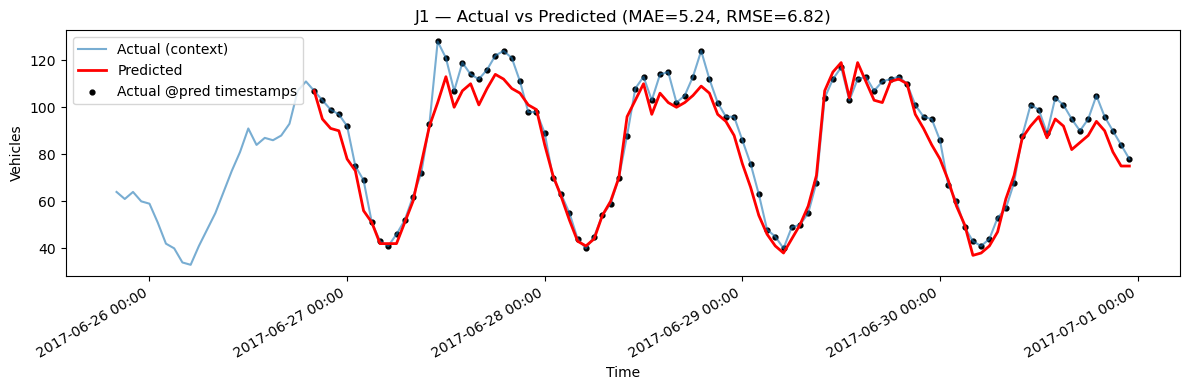

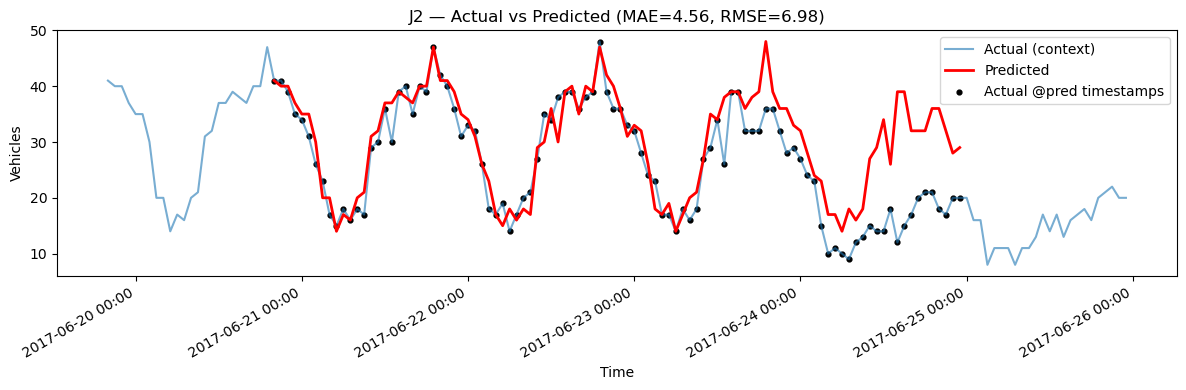

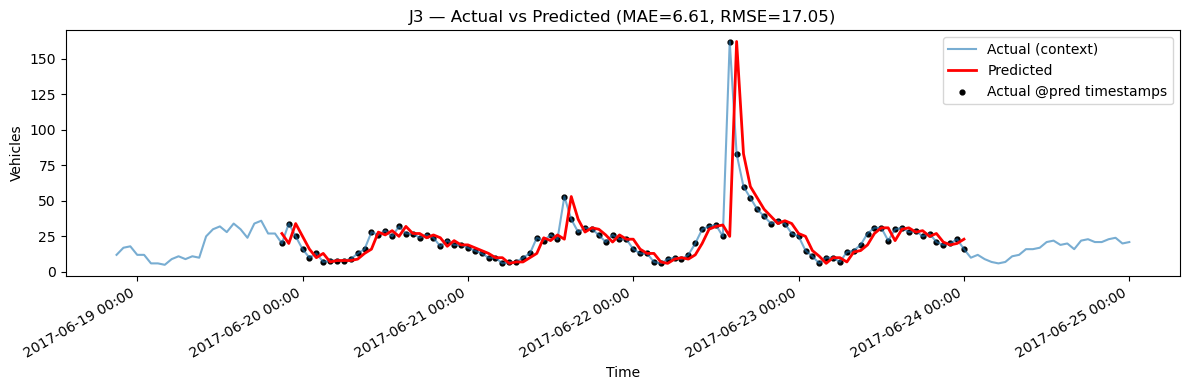

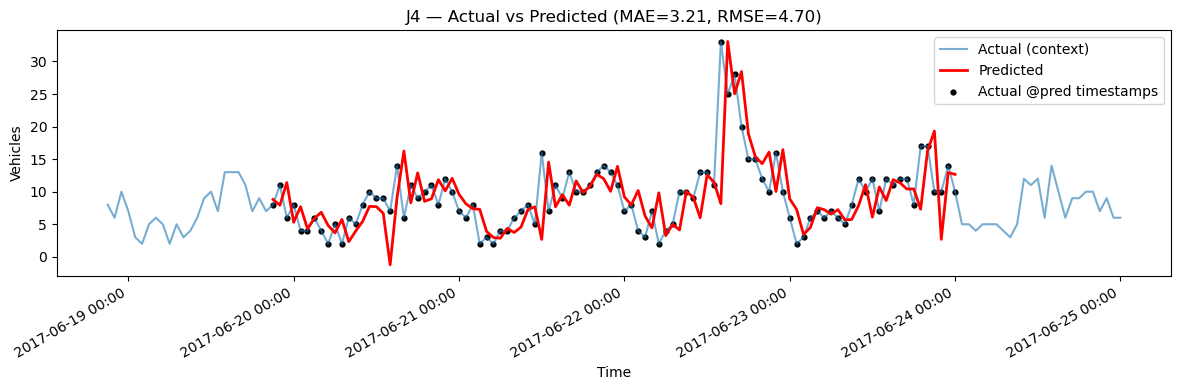

Done plotting all junctions.


In [50]:
# Plot actual vs predicted for each junction
# Requires: `real_preds`, `norm_preds`, `raw_map` to be defined (they are created earlier in the notebook)
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.dates as mdates

for name, pred in real_preds.items():
    # Get raw actual series
    cfg = raw_map.get(name)
    if cfg is None:
        print(f"Skipping {name}: no raw_map entry")
        continue
    raw = cfg['raw_df']
    if isinstance(raw, pd.DataFrame):
        if 'Vehicles' in raw.columns:
            actual = raw['Vehicles']
        else:
            actual = raw.iloc[:, 0]
    else:
        actual = raw

    # Ensure datetime index on actual
    if not hasattr(actual.index, 'dtype') or not pd.api.types.is_datetime64_any_dtype(actual.index):
        try:
            actual.index = pd.to_datetime(actual.index)
        except Exception:
            # if index not convertible, create a RangeIndex
            actual.index = pd.RangeIndex(len(actual))

    # Align predicted and actual timestamps
    pred_idx = pred.index
    # If predicted index spans beyond actual's index, limit to intersection
    common_idx = actual.index.intersection(pred_idx)

    if len(common_idx) == 0:
        # Try to slice actual by the predicted time range
        try:
            start, end = pred_idx[0], pred_idx[-1]
            window_actual = actual.loc[start:end]
        except Exception:
            window_actual = actual
        # Reindex prediction to window_actual (may produce NaNs)
        pred_reindexed = pred.reindex(window_actual.index)
        actual_subset = window_actual
    else:
        actual_subset = actual.loc[common_idx]
        pred_reindexed = pred.reindex(common_idx)

    # Drop any NA pairs
    mask = (~actual_subset.isna()) & (~pred_reindexed.isna())
    actual_vals = actual_subset[mask]
    pred_vals = pred_reindexed[mask]

    if len(actual_vals) == 0:
        print(f"No overlapping actual values found for {name}, skipping plot.")
        continue

    mae = mean_absolute_error(actual_vals, pred_vals)
    rmse = mean_squared_error(actual_vals, pred_vals, squared=False)

    # Plot
    plt.figure(figsize=(12, 4))
    # Plot a window of actual values that covers the prediction range for context
    try:
        start_vis = pred_vals.index[0] - pd.Timedelta(hours=24)
        end_vis = pred_vals.index[-1] + pd.Timedelta(hours=24)
        context_actual = actual.loc[start_vis:end_vis]
    except Exception:
        # fallback: use last len(pred_vals) points
        context_actual = actual.iloc[-len(pred_vals):]

    plt.plot(context_actual.index, context_actual.values, label='Actual (context)', alpha=0.6)
    plt.plot(pred_vals.index, pred_vals.values, label='Predicted', color='red', linewidth=2)
    plt.scatter(pred_vals.index, actual_vals.values, label='Actual @pred timestamps', color='black', s=12)

    plt.title(f"{name} — Actual vs Predicted (MAE={mae:.2f}, RMSE={rmse:.2f})")
    plt.xlabel('Time')
    plt.ylabel('Vehicles')
    plt.legend()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.show()

print('Done plotting all junctions.')